In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
import pickle

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from Bio.SeqUtils.ProtParam import ProteinAnalysis
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


%matplotlib inline

import itertools 
from collections import Counter


In [2]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee', 
            'safe_loans'# total late fees received to day
           ]

target = 'safe_loans'                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
print(len(features))

13


In [3]:
import json

#with open('module-5-assignment-1-train-idx.json') as f:
    #train_idx = json.load(f)

#train_data = loans.iloc[train_idx]

#print(train_data)


In [4]:
df_lending = pd.read_csv('lending-club-data.csv')

df_lending.head()

/Users/scottlew/anaconda2/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


In [5]:
df_lending.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,grade_num,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,last_delinq_none,last_record_none,last_major_derog_none
count,1.226070e+05,1.226070e+05,122607.000000,122607.000000,122607.000000,122607.000000,122607.000000,1.226030e+05,122607.000000,122578.000000,...,122607.000000,122607.000000,122578.000000,122578.000000,122462.000000,122607.000000,122603.000000,122607.000000,122607.000000,122607.000000
mean,4.728452e+06,5.493222e+06,12809.733743,12736.123753,12497.828395,13.639487,396.623285,7.138502e+04,15.496888,0.211996,...,4.232882,0.597509,0.858107,0.908173,0.996734,0.123672,7.564725,0.588115,0.897795,0.873906
std,5.938517e+06,6.604693e+06,7932.313398,7887.167118,7946.731527,4.390836,239.475936,5.841483e+04,7.497442,0.662052,...,1.362138,0.278934,0.348942,0.288783,0.057059,0.329208,4.127291,0.492177,0.302918,0.331957
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.028895,0.000000,0.000000,0.000000
25%,8.532925e+05,1.064872e+06,6700.000000,6625.000000,6271.000000,10.620000,215.985000,4.405250e+04,9.880000,0.000000,...,3.000000,0.400000,1.000000,1.000000,1.000000,0.000000,4.362575,0.000000,1.000000,1.000000
50%,1.621401e+06,1.879659e+06,11000.000000,10950.000000,10500.000000,13.480000,348.180000,6.000000e+04,15.260000,0.000000,...,4.000000,0.600000,1.000000,1.000000,1.000000,0.000000,6.965760,1.000000,1.000000,1.000000
75%,6.699942e+06,8.117948e+06,17600.000000,17425.000000,17000.000000,16.290000,521.930000,8.500000e+04,20.850000,0.000000,...,5.000000,0.800000,1.000000,1.000000,1.000000,0.000000,10.215850,1.000000,1.000000,1.000000
max,3.784128e+07,4.060424e+07,35000.000000,35000.000000,35000.000000,26.060000,1408.130000,7.141778e+06,39.880000,29.000000,...,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,54.171000,1.000000,1.000000,1.000000


In [6]:
df_lending.dtypes

id                               int64
member_id                        int64
loan_amnt                        int64
funded_amnt                      int64
funded_amnt_inv                  int64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
is_inc_v                        object
issue_d                         object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs              

In [7]:
df_lending.isna().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                        6840
emp_length                       4091
home_ownership                      0
annual_inc                          4
is_inc_v                            0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                            61902
purpose                             0
title                              11
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        29
earliest_cr_

In [8]:
df_lending.shape

(122607, 68)

In [9]:
df_lending.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

In [10]:
df_lending['safe_loans'] = df_lending['bad_loans'].apply(lambda x : +1 if x==0 else -1)

df_lending.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

In [11]:
df_lending['safe_loans'].value_counts()

 1    99457
-1    23150
Name: safe_loans, dtype: int64

In [12]:
df_lending.shape

(122607, 69)

In [13]:
df_data = df_lending[features]

df_data.shape

(122607, 13)

In [14]:
# Using Pandas one-hot encoding method instead of scikitlearn
# Get dummies
df_data = pd.get_dummies(df_data, prefix_sep='_', drop_first=True)
# X head
df_data.head()

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_B,grade_C,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months
0,0,11,27.65,1,1,83.7,0.00,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1.00,1,1,9.4,0.00,-1,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,11,8.72,1,1,98.5,0.00,1,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,11,20.00,0,1,21.0,16.97,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0,4,11.20,1,1,28.3,0.00,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [15]:
# X head
df_data.shape

(122607, 63)

In [16]:
df_data.columns

Index(['short_emp', 'emp_length_num', 'dti', 'last_delinq_none',
       'last_major_derog_none', 'revol_util', 'total_rec_late_fee',
       'safe_loans', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
       'grade_G', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3',
       'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3',
       'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2',
       'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5', 'home_ownership_OTHER',
       'home_ownership_OWN', 'home_ownership_RENT', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'p

In [17]:
safe_data = df_data.loc[df_data['safe_loans'] == +1]
risky_data = df_data.loc[df_data['safe_loans'] == -1]

print(safe_data.shape)
print()
print(risky_data.shape)

(99457, 63)

(23150, 63)


In [18]:
safe_data = safe_data.sample(frac=0.22)

safe_data.shape

(21881, 63)

In [19]:
df_balanced = pd.concat([safe_data,risky_data])

df_balanced.shape

(45031, 63)

In [20]:
X = df_balanced.drop(['safe_loans'], axis=1)

y = df_balanced['safe_loans']

# balanced data 

# split the data: training & test sets imbalanced data
X_train, X_test, y_train, y_test = train_test_split(df_balanced,y, test_size=0.2)
print(X_train.shape)
print
print(X_test.shape)
print()
print(y_train.shape)
print
print(y_test.shape)

(36024, 63)
(9007, 63)

(36024,)
(9007,)


In [21]:
y.value_counts()

-1    23150
 1    21881
Name: safe_loans, dtype: int64

In [22]:
X.columns

Index(['short_emp', 'emp_length_num', 'dti', 'last_delinq_none',
       'last_major_derog_none', 'revol_util', 'total_rec_late_fee', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_grade_G5', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house',

In [23]:
X.dtypes

short_emp                       int64
emp_length_num                  int64
dti                           float64
last_delinq_none                int64
last_major_derog_none           int64
revol_util                    float64
total_rec_late_fee            float64
grade_B                         uint8
grade_C                         uint8
grade_D                         uint8
grade_E                         uint8
grade_F                         uint8
grade_G                         uint8
sub_grade_A2                    uint8
sub_grade_A3                    uint8
sub_grade_A4                    uint8
sub_grade_A5                    uint8
sub_grade_B1                    uint8
sub_grade_B2                    uint8
sub_grade_B3                    uint8
sub_grade_B4                    uint8
sub_grade_B5                    uint8
sub_grade_C1                    uint8
sub_grade_C2                    uint8
sub_grade_C3                    uint8
sub_grade_C4                    uint8
sub_grade_C5

In [24]:
dtc = DecisionTreeClassifier(random_state=0)

dtc.fit(X_train,y_train)

score = dtc.score(X_test,y_test)
print('Accuracy score for test data')
print(score)

Accuracy score for test data
1.0


In [25]:
# Generate Confusion Matrix for Logistic Regression
actual = y_test
predictions = dtc.predict(X_test)
print()
cm = confusion_matrix(actual,predictions)
print(cm)


[[4615    0]
 [   0 4392]]


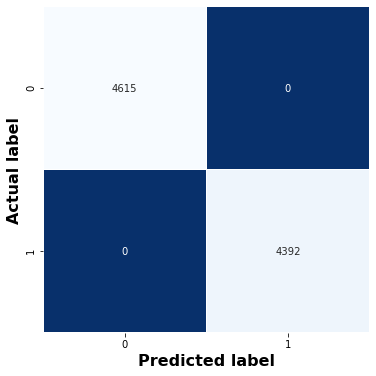

In [26]:
# Confusion matrix for Decision Tree Classifier Model
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r',cbar= None);
plt.ylabel('Actual label',fontsize=16,fontweight='bold');
plt.xlabel('Predicted label',fontsize=16,fontweight='bold');
#plt.savefig('ConfusionMatrix_VotingClassifier_Locations_Model_1.png')

In [27]:
df_balanced.dtypes
numerical_features = []
for item in df_balanced.columns:
    if df_balanced[item].dtype != 'uint8':
        print(df_balanced[item].dtype)
        numerical_features.append(item)
    
print(numerical_features)
print()
print(len(numerical_features))

int64
int64
float64
int64
int64
float64
float64
int64
['short_emp', 'emp_length_num', 'dti', 'last_delinq_none', 'last_major_derog_none', 'revol_util', 'total_rec_late_fee', 'safe_loans']

8


In [28]:
X = df_balanced[numerical_features]
X= X.drop(['safe_loans'],axis=1)
y = df_balanced['safe_loans']

# balanced data 

# split the data: training & test sets imbalanced data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print(X_train.shape)
print
print(X_test.shape)
print()
print(y_train.shape)
print
print(y_test.shape)

(36024, 7)
(9007, 7)

(36024,)
(9007,)


In [29]:
X.columns

Index(['short_emp', 'emp_length_num', 'dti', 'last_delinq_none',
       'last_major_derog_none', 'revol_util', 'total_rec_late_fee'],
      dtype='object')

In [30]:
X.dtypes

short_emp                  int64
emp_length_num             int64
dti                      float64
last_delinq_none           int64
last_major_derog_none      int64
revol_util               float64
total_rec_late_fee       float64
dtype: object

In [31]:
y.value_counts()

-1    23150
 1    21881
Name: safe_loans, dtype: int64

In [32]:
# Logistic Regressio on balanced data
# Instantiate Logistic Regression Model
lr = LogisticRegression(random_state = 3)
# build the model using training data
lr.fit(X_train, y_train)
score = lr.score(X_test,y_test)
print(score)


0.5939824580881536


In [33]:
# Generate Confusion Matrix for Logistic Regression
actual = y_test
predictions = lr.predict(X_test)
print()
cm_lr = confusion_matrix(actual,predictions)
print(cm_lr)


[[2975 1673]
 [1984 2375]]


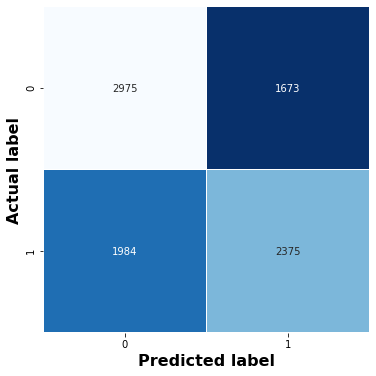

In [34]:
# Confusion matrix for Logistic Regression Classifier Model for Balanced Data
plt.figure(figsize=(6,6))
sns.heatmap(cm_lr, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r',cbar= None);
plt.ylabel('Actual label',fontsize=16,fontweight='bold');
plt.xlabel('Predicted label',fontsize=16,fontweight='bold');
#plt.savefig('ConfusionMatrix_VotingClassifier_Locations_Model_1.png')

In [35]:
# optimize logistic regression model

C_param_range = [0.001,0.01,0.1,1,10,100]

for C_ in C_param_range:
    
    # Apply logistic regression model to training data
    lr = LogisticRegression(C = C_,random_state = 0)
    lr.fit(X_train,y_train)
    score = lr.score(X_test,y_test)
    print(C_, score)
    print

0.001 0.5930942600199844
0.01 0.5942045076051959
0.1 0.5939824580881536
1 0.5939824580881536


/Users/scottlew/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


10 0.5939824580881536
100 0.5940934828466748


In [36]:
###################################################################################################